# <center>Radial Flow [1]</center>

In [1]:
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F

import torchvision

import matplotlib.pyplot as plt
import numpy as np

import sklearn.datasets as datasets

from NF_base import *

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"

**Radial Flows**
\begin{equation*}
    z'=z+\beta h(\alpha,r)(z-z_0)
\end{equation*}
with $h(\alpha,r)=\frac{1}{\alpha+r}$ and $r=\|z-z_0\|_2$. The parameters are $\alpha,\beta\in\mathbb{R}$ and $z_0\in\mathbb{R}^d$.

The Jacobian is:
\begin{align*}
    J(z) &= I+\beta(h'(\alpha,r)(z-z_0)J_r(z)+h(\alpha,r)I) \\
    &= (1+h(\alpha,r))I+\beta h'(\alpha,r)(z-z_0)\frac{(z-z_0)^T}{\|z-z_0\|_2}
\end{align*}

To compute the determinant of the Jacobian, we will use the matrix determinant lemma:
\begin{equation*}
    \det(A+VW^T)=\det(I+W^TA^{-1}V)\det(A)
\end{equation*}
And so:
\begin{align*}
    \det J(z) &= \det\Big((1+h(\alpha,r))I)+\beta h'(\alpha,r)(z-z_0)\frac{(z-z_0)^T}{\|z-z_0\|_2}\Big) \\
    &= \det((1+\beta h(\alpha,r))I)\det\Big(I+\beta\frac{h'(\alpha,r)}{1+\beta h(\alpha,r)}\frac{(z-z_0)(z-z_0)^T}{\|z-z_0\|_2}\Big) \\
    &= (1+\beta h(\alpha,r))^d \det\Big(1+\beta\frac{h'(\alpha,r)}{1+\beta h(\alpha,r)}\frac{\|z-z_0\|_2^2}{\|z-z_0\|_2}\Big) \\
    &= (1+\beta h(\alpha,r))^d \det\Big(\frac{1+\beta h(\alpha,r)+\beta h'(\alpha,r)r}{1+\beta h(\alpha,r)}\Big) \\
    &= (1+\beta h(\alpha,r))^{d-1} (1+\beta h(\alpha,r)+\beta h'(\alpha,r)r) \\
    &= \Big(1+\frac{\beta}{\alpha+r}\Big)^{d-1} \Big(1+\frac{\beta}{\alpha+r}-\frac{\beta r}{(\alpha+r)^2}\Big) \\
    &= \Big(1+\frac{\beta}{\alpha+r}\Big)^{d-1}\Big(1+\frac{\beta\alpha}{(\alpha+r)^2}\Big)
\end{align*}



Problem: invertible only if $\beta>-\alpha$ and no closed-form solution (can't be trained as usual).
To train it, we  normalize here the reverse KL-divergence for with we have to be able to evaluate the target density:

\begin{equation*}
    \min\limits_\theta KL((T_\theta)_\# p_Z||p_X^*)
\end{equation*}

and we have:
\begin{align*}
    KL((T_\theta)_\# p_Z||p_X^*) &= \mathbb{E}_{p_Z}[\log p_Z(z) - \log|\det J_T(z)|-\log p_X^*(T(z))]
\end{align*}

We can approximate it by Monte-Carlo if we can evaluate $p_X^*$.


## Unnormalized 2D densities

Target: $p(z)\propto e^{-U(z)}$

In [4]:
## https://arxiv.org/pdf/1505.05770.pdf

def sigmoid(z):
    return 1/(1+np.exp(-z))

def sigmoidp(z):
    return 1/(1+torch.exp(-z))

def w1(z):
    return np.sin(2*np.pi*z[:,0]/4)

def w1p(z):
    return torch.sin(2*np.pi*z[:,0]/4)

def w2(z):
    cpt = ((z[:,0]-1)/0.6)**2
    return 3*np.exp(-0.5*cpt)

def w2p(z):
    cpt = ((z[:,0]-1)/0.6)**2
    return 3*torch.exp(-0.5*cpt)

def w3(z):
    return 3*sigmoid((z[:,0]-1)/3)

def w3p(z):
    return 3*sigmoidp((z[:,0]-1)/3)

def U1(z):
    cpt1 = ((np.linalg.norm(z,axis=1)-2)/0.4)**2
    cpt2 = -0.5*((z[:,0]-2)/0.6)**2
    cpt3 = -0.5*((z[:,0]+2)/0.6)**2
    return cpt1-np.log(np.exp(cpt2)+np.exp(cpt3))

def U1p(z):
    cpt1 = ((torch.sqrt(z[:,0]**2+z[:,1]**2)-2)/0.4)**2
    cpt1 = ((torch.sqrt(torch.sum(z**2,dim=1))-2)/0.4)**2
    cpt2 = -0.5*((z[:,0]-2)/0.6)**2
    cpt3 = -0.5*((z[:,0]+2)/0.6)**2
    return cpt1-torch.log(torch.clamp(torch.exp(cpt2)+torch.exp(cpt3),min=1e-6))

def U2(z):
    return 0.5*((z[:,1]-w1(z))/0.4)**2

def U2p(z):
    return 0.5*((z[:,1]-w1p(z))/0.4)**2

def U3(z):
    cpt1 = ((z[:,1]-w1(z))/0.35)**2
    cpt2 = ((z[:,1]-w1(z)+w2(z))/0.35)**2
    return -np.log(np.exp(-0.5*cpt1)+np.exp(-0.5*cpt2))

def U3p(z):
    cpt1 = ((z[:,1]-w1p(z))/0.35)**2
    cpt2 = ((z[:,1]-w1p(z)+w2p(z))/0.35)**2
    return -torch.log(torch.clamp(torch.exp(-0.5*cpt1)+torch.exp(-0.5*cpt2),min=1e-6))

def U4(z):
    cpt1 = ((z[:,1]-w1(z))/0.4)**2
    cpt2 = ((z[:,1]-w1(z)+w3(z))/0.35)**2
    return -np.log(np.exp(-0.5*cpt1)+np.exp(-0.5*cpt2))

def U4p(z):
    cpt1 = ((z[:,1]-w1p(z))/0.4)**2
    cpt2 = ((z[:,1]-w1p(z)+w3p(z))/0.35)**2
    return -torch.log(torch.clamp(torch.exp(-0.5*cpt1)+torch.exp(-0.5*cpt2),min=1e-6))

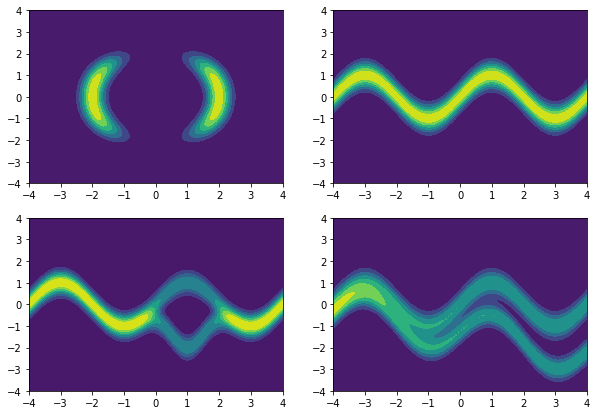

In [5]:
xline = np.linspace(-4, 4, 100)
yline = np.linspace(-4, 4, 100)
xgrid, ygrid = np.meshgrid(xline, yline)
xyinput = np.concatenate([xgrid.reshape(-1, 1), ygrid.reshape(-1, 1)], axis=1)

zz = np.exp(-U1(xyinput)) # np.exp(-xyinput.sum(axis=1))
zgrid1 = zz.reshape(100,100)

zz = np.exp(-U2(xyinput)) # np.exp(-xyinput.sum(axis=1))
zgrid2 = zz.reshape(100,100)

zz = np.exp(-U3(xyinput)) # np.exp(-xyinput.sum(axis=1))
zgrid3 = zz.reshape(100,100)

zz = np.exp(-U4(xyinput)) # np.exp(-xyinput.sum(axis=1))
zgrid4 = zz.reshape(100,100)

fig,ax = plt.subplots(2,2,figsize=(10,7))

ax[0,0].contourf(xgrid, ygrid, zgrid1)
ax[0,1].contourf(xgrid, ygrid, zgrid2)
ax[1,0].contourf(xgrid, ygrid, zgrid3)
ax[1,1].contourf(xgrid, ygrid, zgrid4)
plt.show()

In [6]:
def kl_reverse(z,x,log_det,true_density):
    log_pz = base_distr.log_prob(z)
    log_pX = torch.log(torch.clamp(true_density(x),min=1e-20)) ## only need unnormalized density
    return torch.mean(log_pz-log_det-log_pX,dim=0)

In [7]:
def train_shapes(model,n_batch=500,n_epochs=10001,U=U1p):
    true_density = lambda x : torch.exp(-U(x))

    train_loss = []

    for i in range(n_epochs):
        if i%100==0:
            print(i)

        model.train()

        z0 = torch.randn(n_batch,2,device=device)
        xs,log_det = model(z0)

        loss = kl_reverse(z0,xs[-1],log_det,true_density)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        train_loss.append(loss.item())
        if i%100==0:
            print(loss)

    return train_loss

In [8]:
base_distr = torch.distributions.multivariate_normal.MultivariateNormal(
    torch.zeros(2,device=device),torch.eye(2,device=device))

### $U_1$

In [9]:
radialFlows = [RadialFlow(2) for k in range(32)]
model = NormalizingFlows(radialFlows)

model = model.to(device)

# optimizer = optim.RMSprop(model.parameters(),lr=1e-5,momentum=0.9)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)
print("number of params: ", sum(p.numel() for p in model.parameters()))

number of params:  128


In [10]:
train_loss = train_shapes(model,U=U1p,n_epochs=2001)

0
tensor(34.2842, device='cuda:0', grad_fn=<MeanBackward1>)
100
tensor(-0.3773, device='cuda:0', grad_fn=<MeanBackward1>)
200
tensor(-0.7910, device='cuda:0', grad_fn=<MeanBackward1>)
300
tensor(-0.8587, device='cuda:0', grad_fn=<MeanBackward1>)
400
tensor(-0.8364, device='cuda:0', grad_fn=<MeanBackward1>)
500
tensor(-0.8489, device='cuda:0', grad_fn=<MeanBackward1>)
600
tensor(-0.8688, device='cuda:0', grad_fn=<MeanBackward1>)
700
tensor(-0.8504, device='cuda:0', grad_fn=<MeanBackward1>)
800
tensor(-0.8695, device='cuda:0', grad_fn=<MeanBackward1>)
900
tensor(-0.8693, device='cuda:0', grad_fn=<MeanBackward1>)
1000
tensor(-0.8749, device='cuda:0', grad_fn=<MeanBackward1>)
1100
tensor(-0.8652, device='cuda:0', grad_fn=<MeanBackward1>)
1200
tensor(-0.8892, device='cuda:0', grad_fn=<MeanBackward1>)
1300
tensor(-0.8521, device='cuda:0', grad_fn=<MeanBackward1>)
1400
tensor(-1.0916, device='cuda:0', grad_fn=<MeanBackward1>)
1500
tensor(-1.3639, device='cuda:0', grad_fn=<MeanBackward1>)
1600

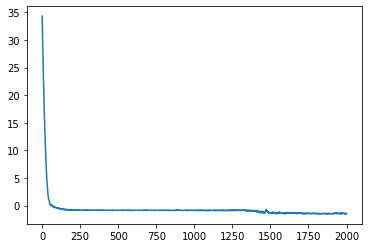

In [11]:
plt.plot(train_loss)
plt.show()

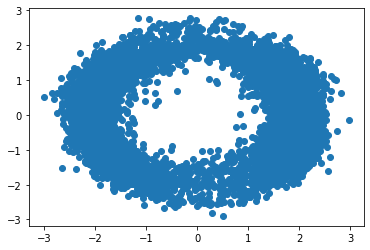

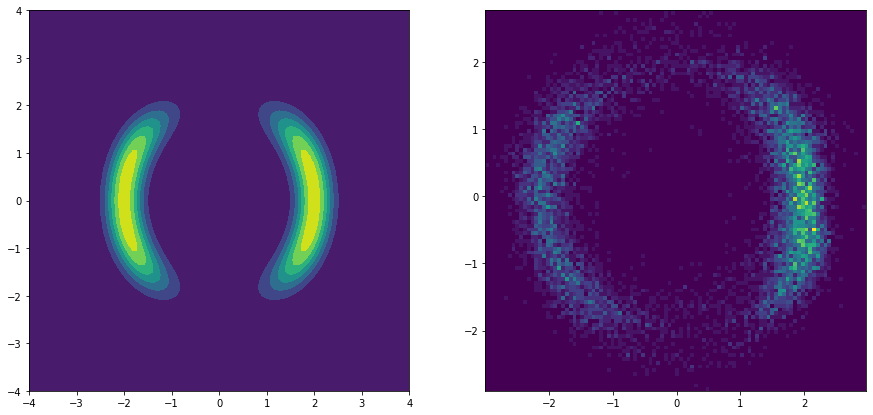

In [12]:
z,_ = model(torch.randn(10000,2,device=device))
samples = z[-1].detach().cpu().numpy()

plt.scatter(samples[:,0],samples[:,1])
plt.show()

fig,ax = plt.subplots(1,2,figsize=(15,7))

ax[0].contourf(xgrid, ygrid, zgrid1)
ax[1].hist2d(samples[:,0],samples[:,1],bins=100)
plt.show()

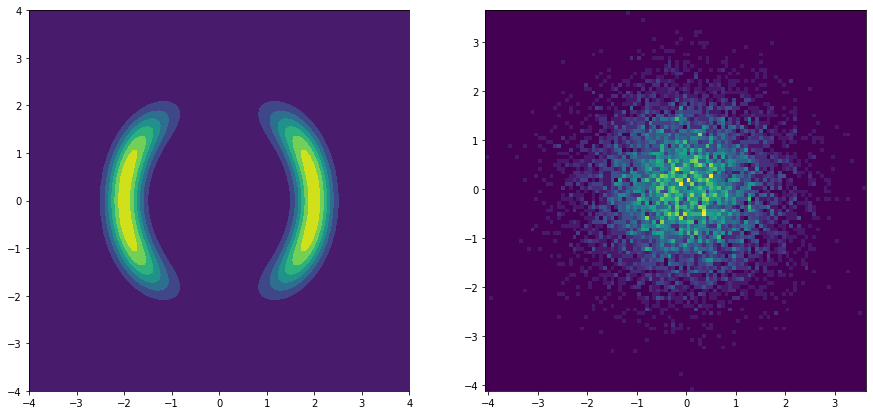

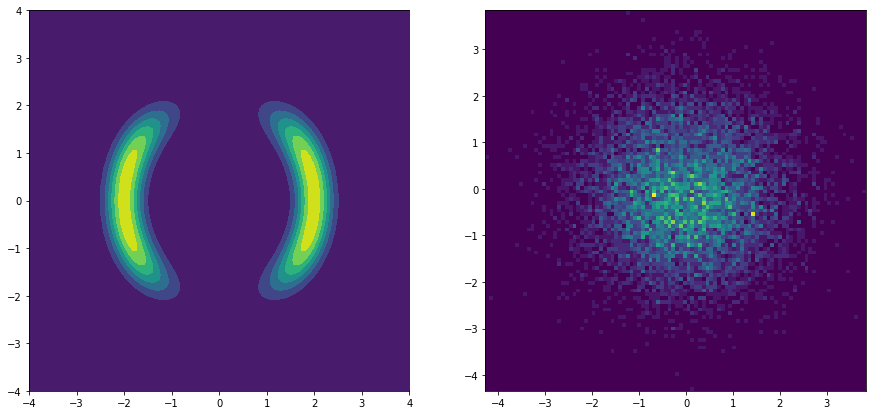

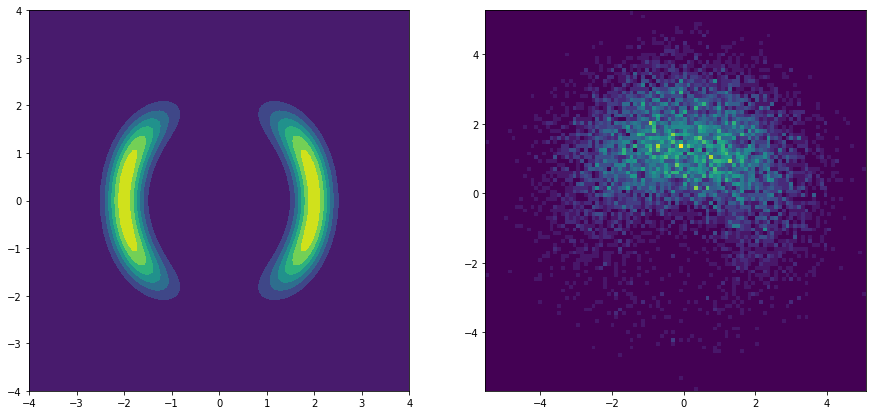

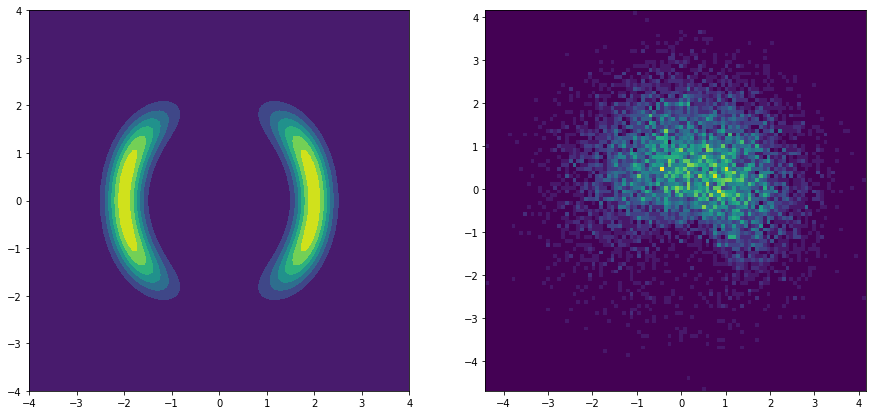

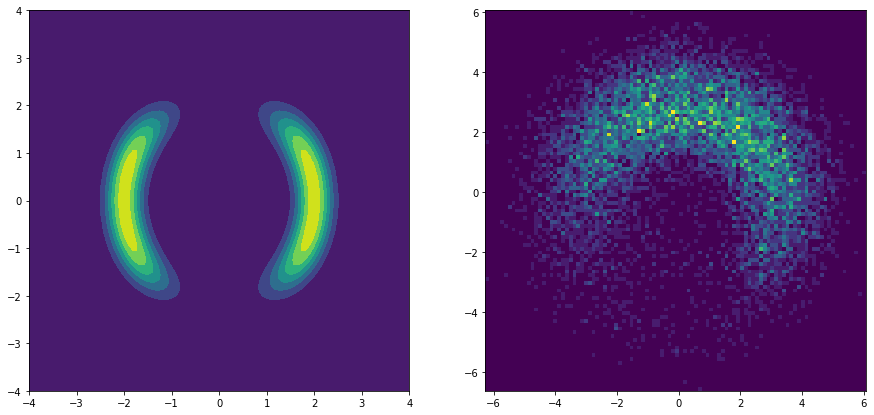

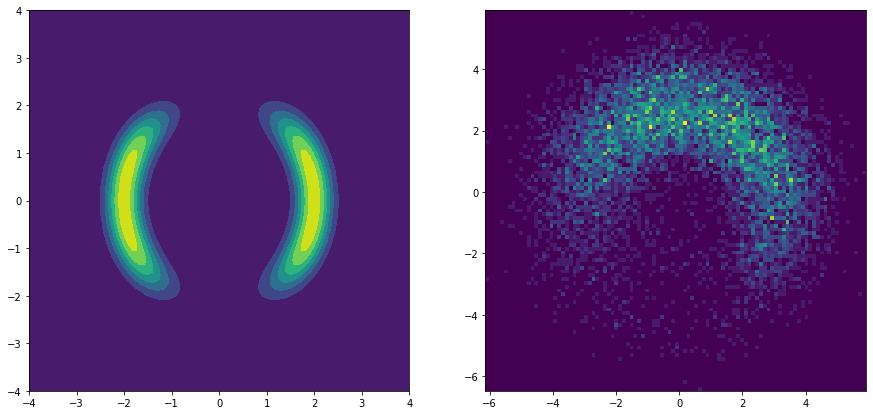

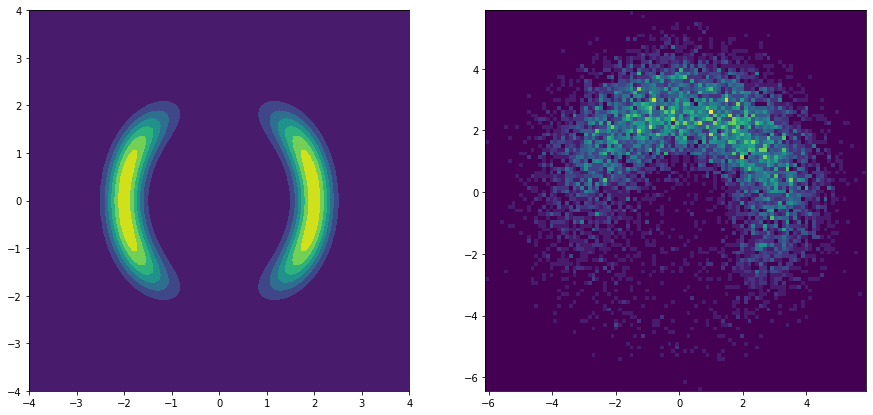

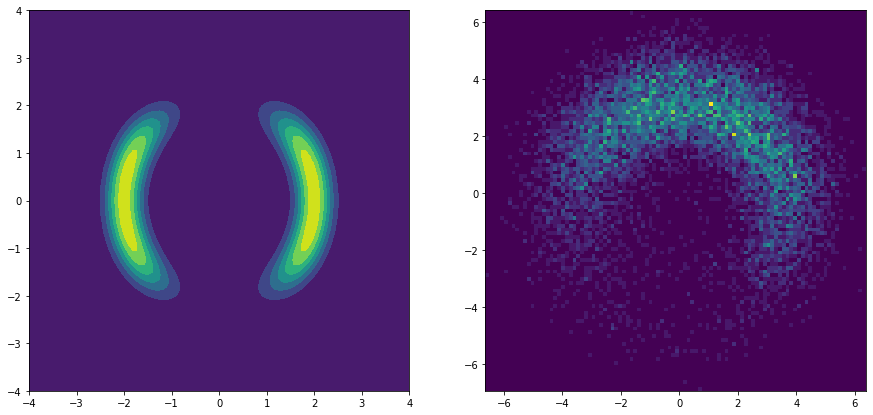

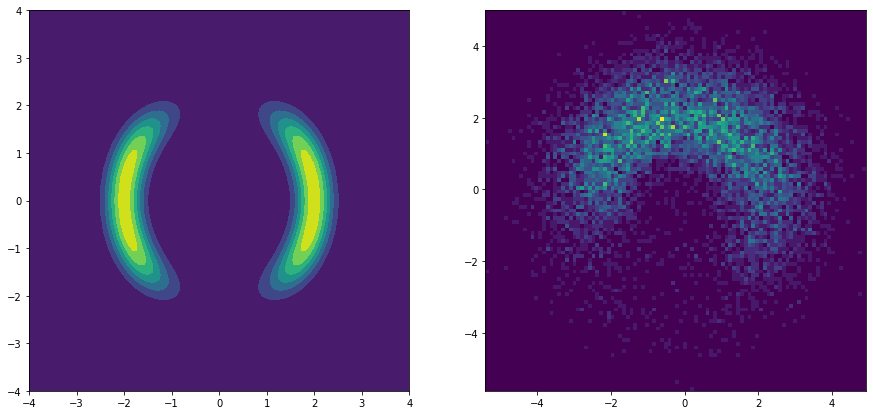

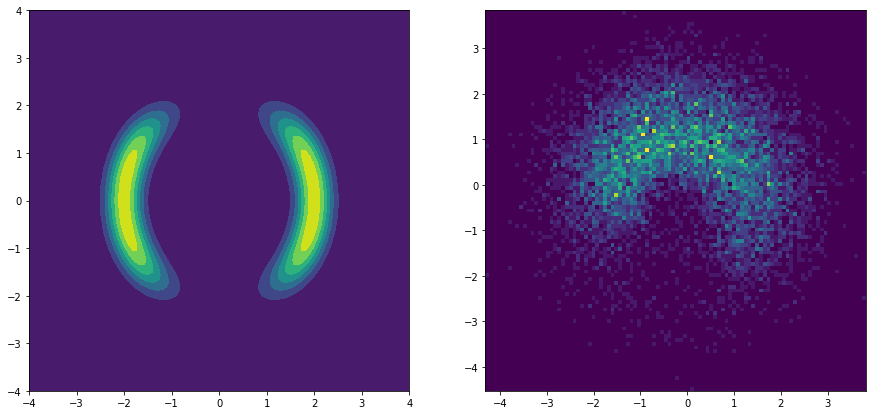

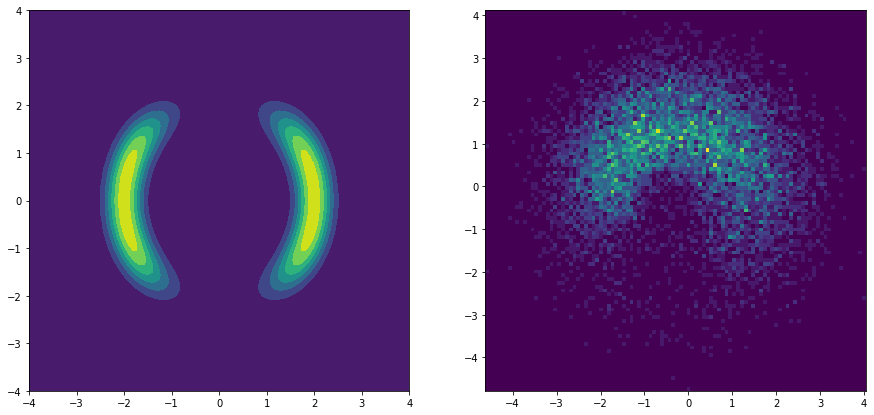

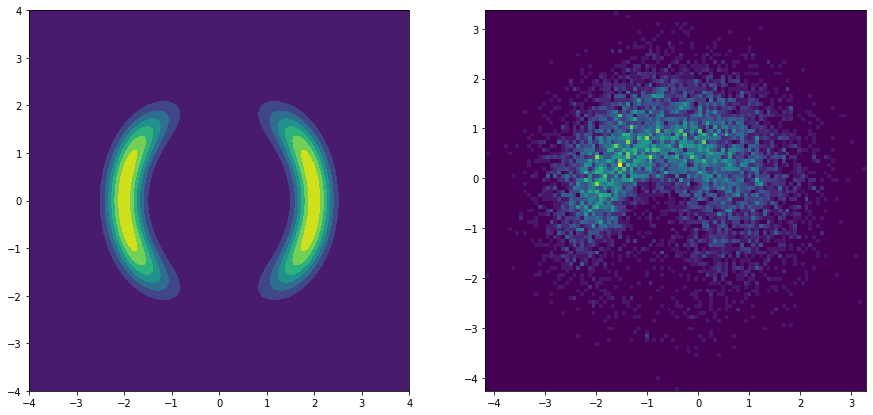

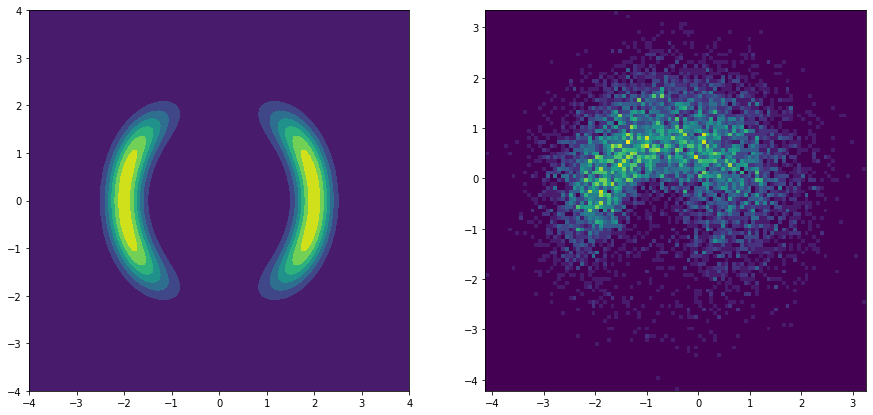

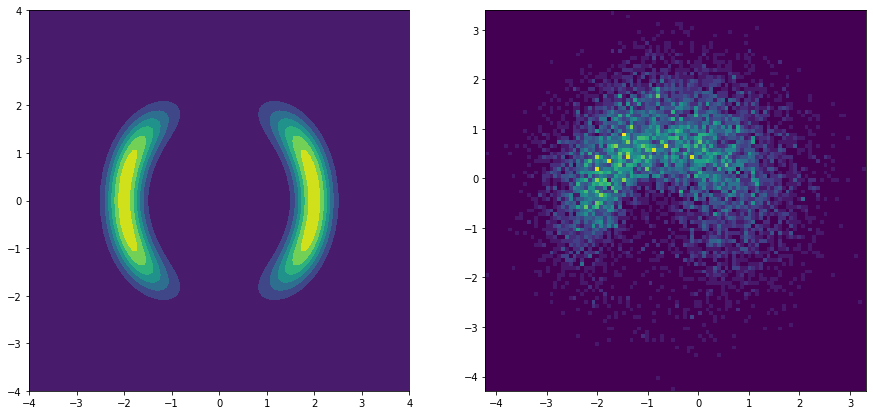

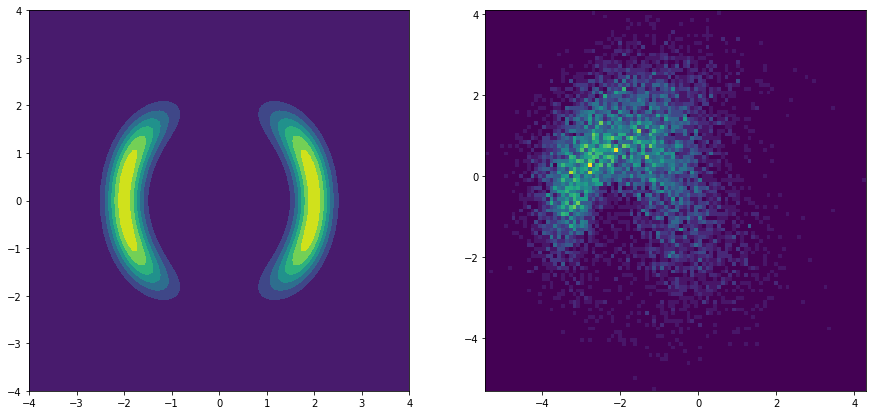

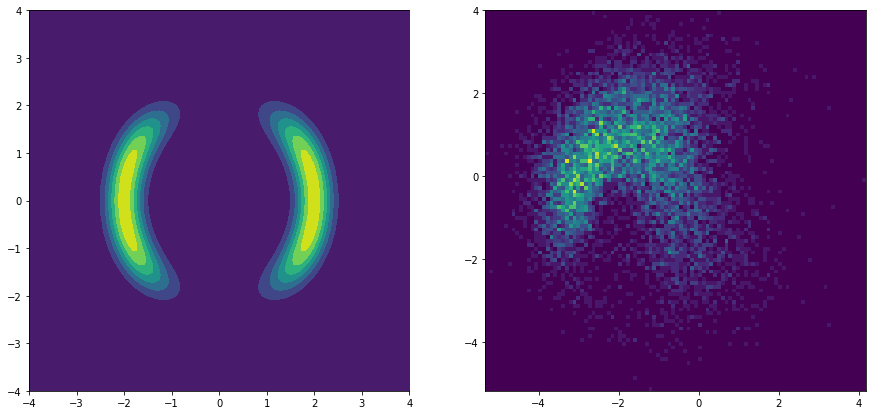

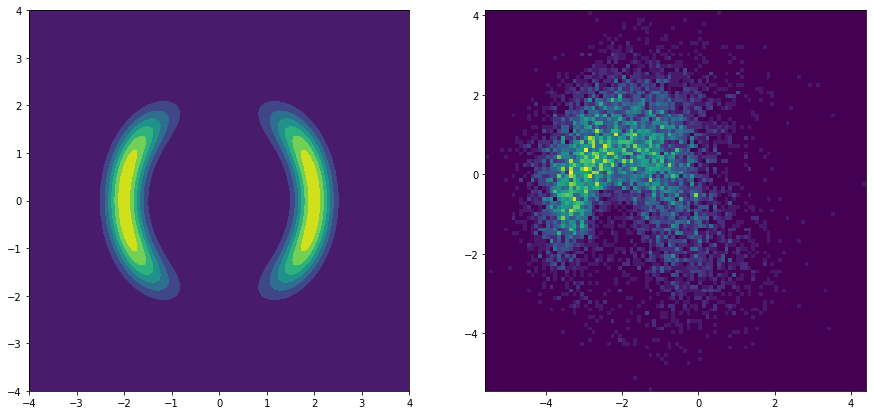

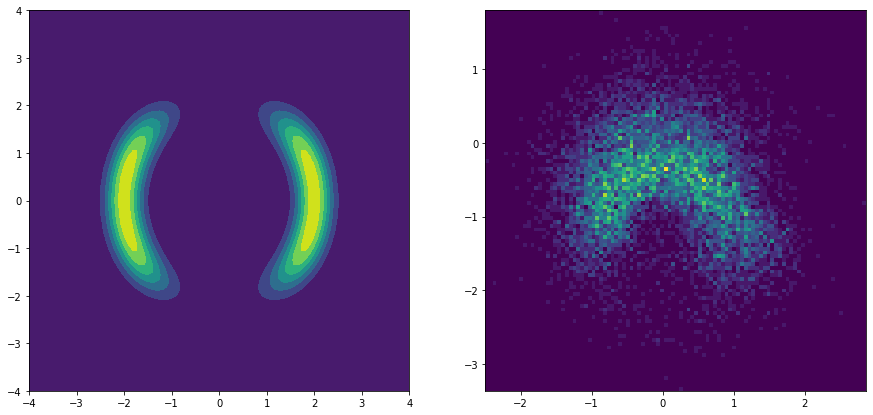

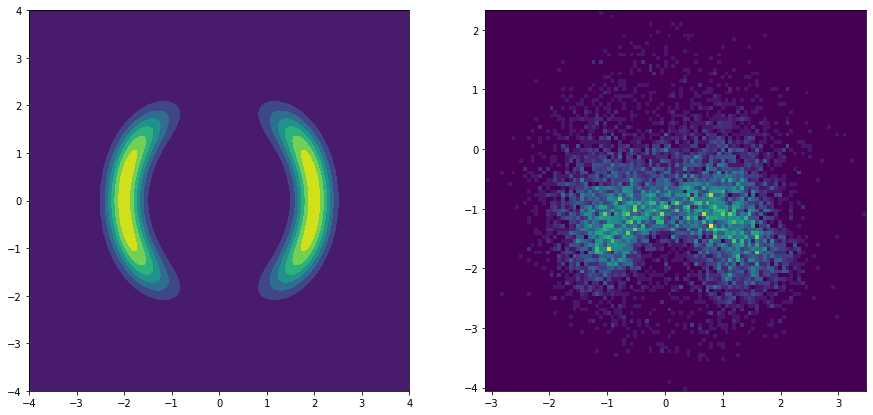

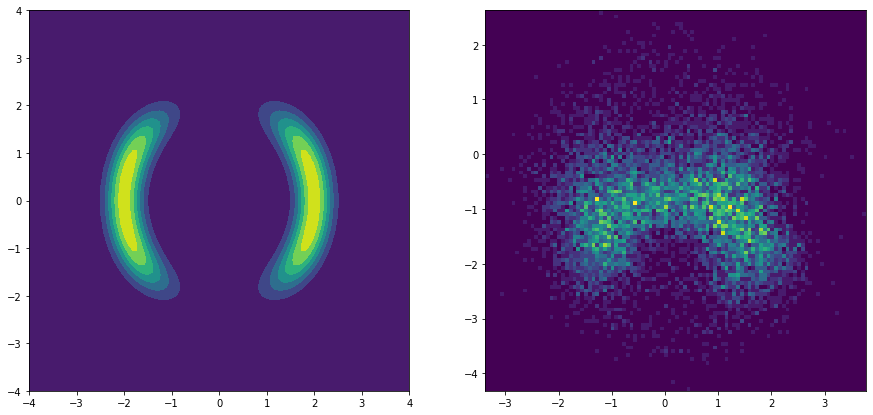

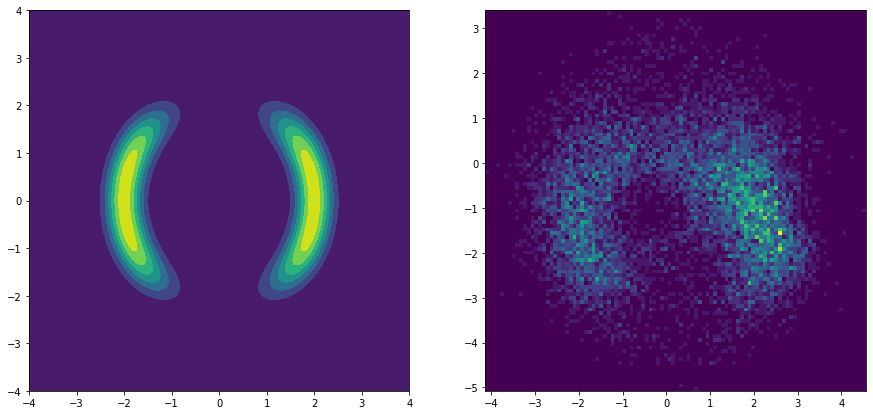

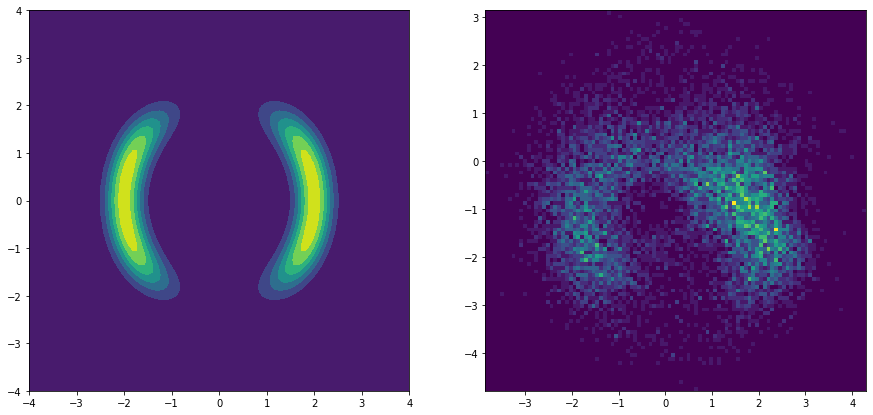

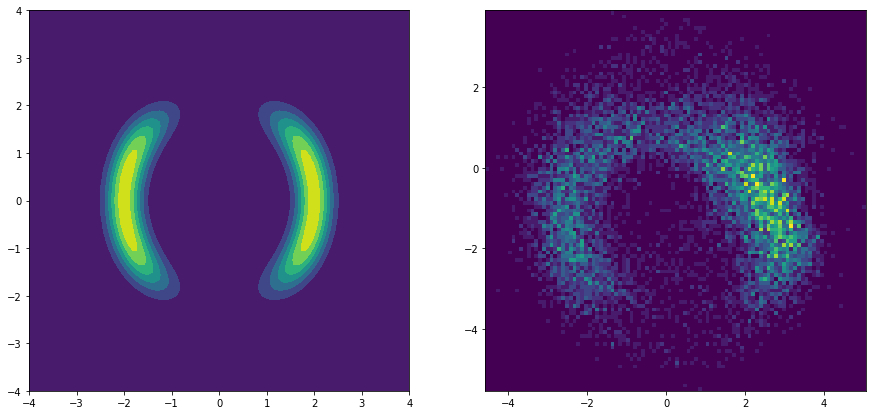

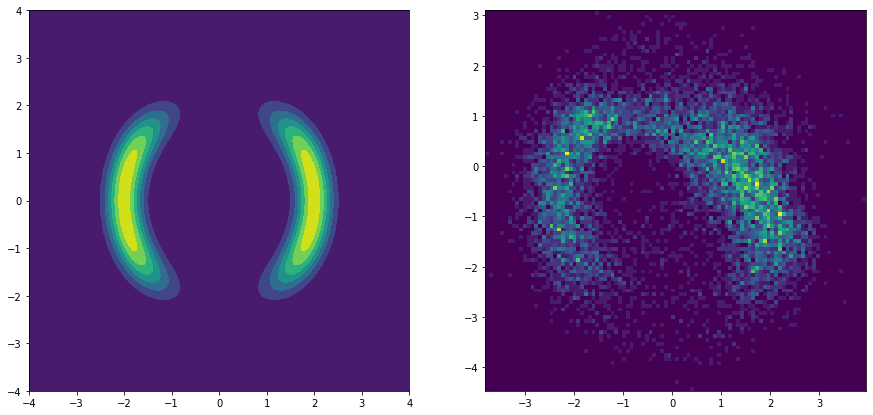

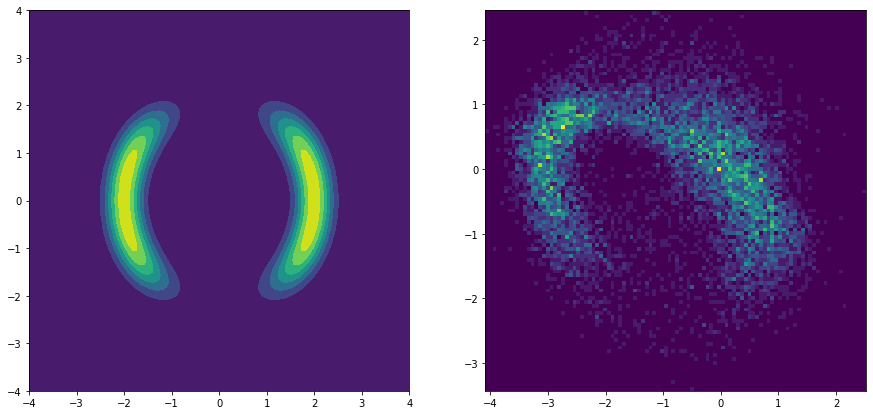

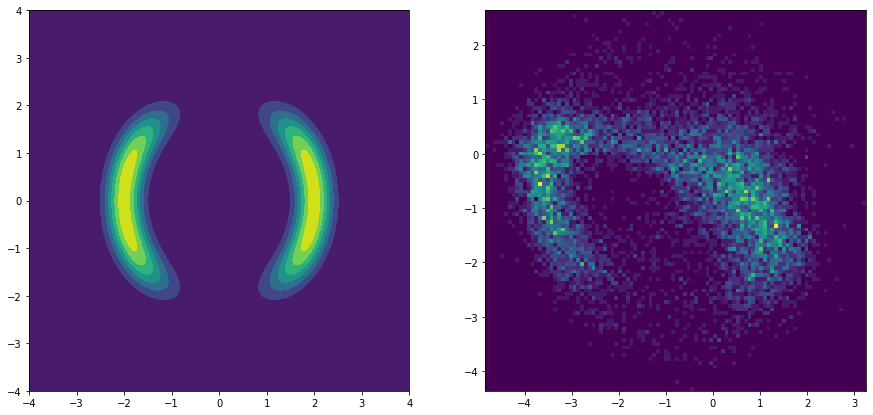

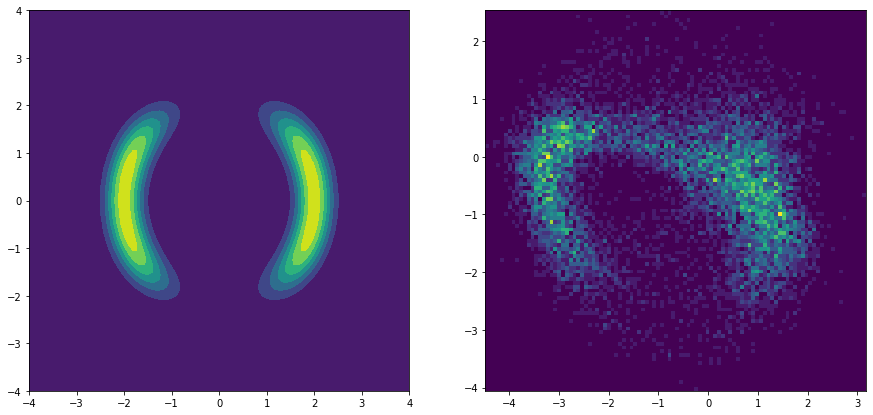

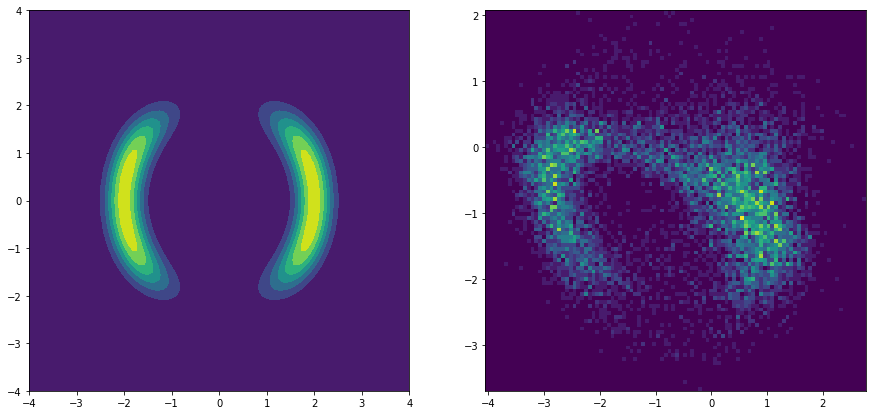

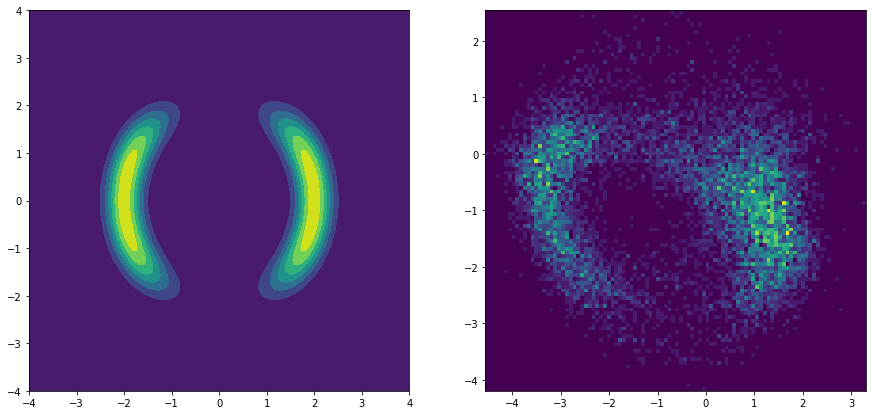

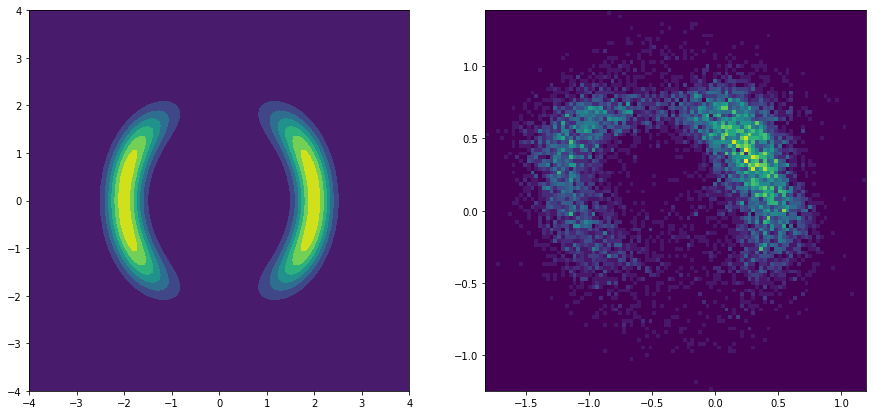

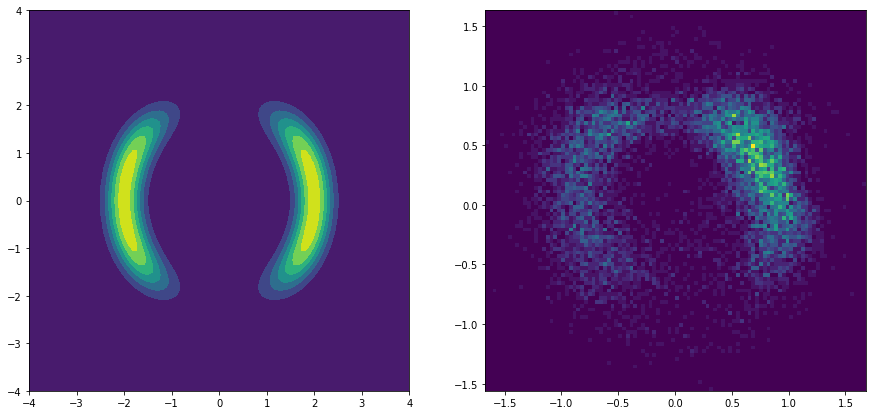

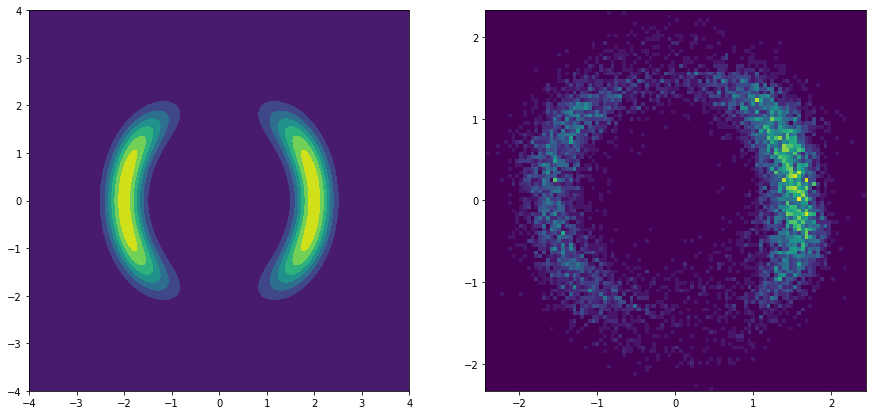

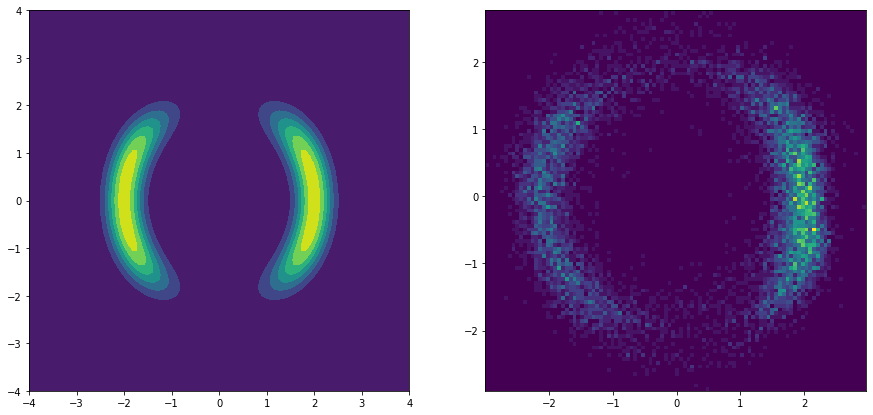

In [13]:
for i in range(len(z)):
    sample = z[i].detach().cpu().numpy()
    fig,ax = plt.subplots(1,2,figsize=(15,7))

    ax[0].contourf(xgrid, ygrid, zgrid1)
    ax[1].hist2d(sample[:,0],sample[:,1],bins=100)
    plt.show()

### $U_2$

In [14]:
radialFlows = [RadialFlow(2) for k in range(32)]
model = NormalizingFlows(radialFlows)

model = model.to(device)

# optimizer = optim.RMSprop(model.parameters(),lr=1e-5,momentum=0.9)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)

In [15]:
train_loss = train_shapes(model,U=U2p,n_epochs=2001 )

0
tensor(5.6125, device='cuda:0', grad_fn=<MeanBackward1>)
100
tensor(-0.8437, device='cuda:0', grad_fn=<MeanBackward1>)
200
tensor(-1.0673, device='cuda:0', grad_fn=<MeanBackward1>)
300
tensor(-1.3031, device='cuda:0', grad_fn=<MeanBackward1>)
400
tensor(-1.3670, device='cuda:0', grad_fn=<MeanBackward1>)
500
tensor(-1.5226, device='cuda:0', grad_fn=<MeanBackward1>)
600
tensor(-1.4881, device='cuda:0', grad_fn=<MeanBackward1>)
700
tensor(-1.5860, device='cuda:0', grad_fn=<MeanBackward1>)
800
tensor(-1.6610, device='cuda:0', grad_fn=<MeanBackward1>)
900
tensor(-1.6621, device='cuda:0', grad_fn=<MeanBackward1>)
1000
tensor(-1.7148, device='cuda:0', grad_fn=<MeanBackward1>)
1100
tensor(-1.7261, device='cuda:0', grad_fn=<MeanBackward1>)
1200
tensor(-1.7610, device='cuda:0', grad_fn=<MeanBackward1>)
1300
tensor(-1.8625, device='cuda:0', grad_fn=<MeanBackward1>)
1400
tensor(-1.9486, device='cuda:0', grad_fn=<MeanBackward1>)
1500
tensor(-1.9918, device='cuda:0', grad_fn=<MeanBackward1>)
1600


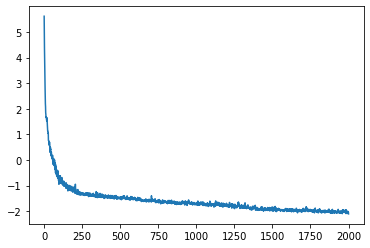

In [16]:
plt.plot(train_loss)
plt.show()

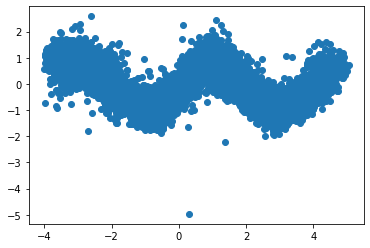

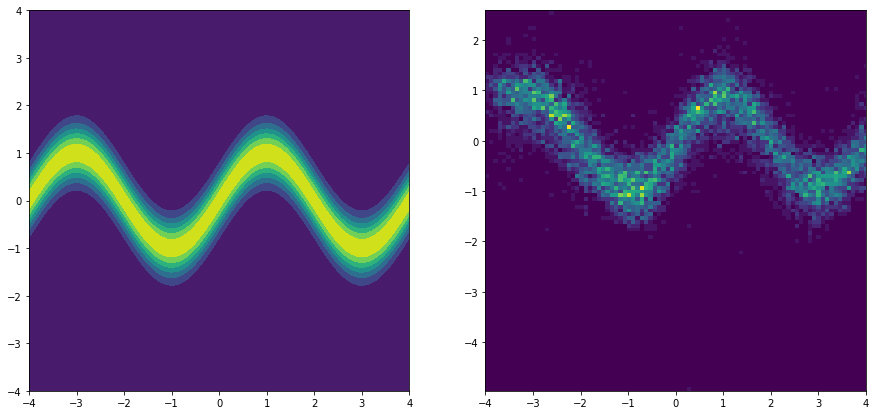

In [17]:
samples,_ = model(torch.randn(10000,2,device=device))
samples = samples[-1].detach().cpu().numpy()

plt.scatter(samples[:,0],samples[:,1])
plt.show()

fig,ax = plt.subplots(1,2,figsize=(15,7))

ax[0].contourf(xgrid, ygrid, zgrid2)
ax[1].hist2d(samples[:,0],samples[:,1],bins=100)
ax[1].set_xlim(-4,4)
plt.show()

## Variational Encoder with NF

ELBO:
We have:
\begin{align*}
    \log p_\theta(x)&\geq \log p_\theta(x)-KL(q(\cdot|x)||p_\theta(\cdot|x))\\
    &= \int \log(\frac{p_\theta(x,z)}{q(z|x)})q(z|x)dz \\
    &= \mathbb{E}_{q(\cdot|x)}[p_\theta(x|z)]-KL(q(\cdot|x)||p_\theta) \\
    &= -\mathcal{F}(\theta)
\end{align*}

**Variational Encoder**:
- encoder: $q_\phi(z|x)$
- decoder: $p_\theta(x|z)$

Example for classical VAE:
- encoder: $q_\phi(z|x)=\mathcal{N}(z;\mu,\sigma^2 I)$
- apriori: $p_\theta(z)=\mathcal{N}(z;0,I)$
- decoder: $p_\theta(x|z)=\mathcal{N}(x;\mu(z),\sigma^2(z))$ or $p_\theta(x|z)=\text{Ber}(D(z))$

**VAE with NF**: 

Idea: improve the class of distribution for the variational inference with a normalizing flow in the latent space (e.g. not just a mean field approximation with gaussians anymore).

- $q_0(z|x)=\mathcal{N}(z;\mu(x),\sigma^2(x))$

Let $z_0\sim q_0(\cdot|x)$,

- $z_K = f_K\circ\dots\circ f_1(z_0) = f(z_0)$
- $q_K(z_K|x) = q_0(z_0|x)|\det J_f(f^{-1}(z_K))|^{-1}$
- $\log q_K(z_K|x) = \log q_0(z_0|x) - \sum_{k=1}^K \log |\det \frac{\partial f_k}{\partial z_{k-1}}(z_{k-1})|$

Then, denoting $q_\phi=q_K$, the ELBO transforms as:

\begin{align*}
    \mathcal{F}(\theta,\phi) &= \mathbb{E}_{q_\phi}[\log q_\phi(z|x)-\log p_\theta(x,z)] \\
    &= \mathbb{E}_{q_0}[\log q_0(z_0|x)-\log p_\theta(x,f(z_0))-\sum_{k=1}^K \log |\det \frac{\partial f_k}{\partial z_{k-1}}(z_{k-1})|]
\end{align*}

In [18]:
def uniform_quantization(img):
    return (img*255+torch.rand(img.size()))/256

def rescale_logit(img,lambd=1e-6):
    ## logit space
    return torch.logit(lambd+(1-2*lambd)*img)

In [19]:
transform = torchvision.transforms.Compose([
                torchvision.transforms.ToTensor()#,
#                 uniform_quantization,
#                 rescale_logit
                # torchvision.transforms.Normalize((0.5,), (0.5,))
    ])

train_dataset = torchvision.datasets.MNIST(
    root="~/torch_datasets", train=True, transform=transform, download=True
)

test_dataset = torchvision.datasets.MNIST(
    root="~/torch_datasets", train=False, transform=transform, download=True
)

train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=128, shuffle=True, num_workers=4, pin_memory=True
)

test_loader = torch.utils.data.DataLoader(
    test_dataset, batch_size=32, shuffle=False, num_workers=4
)

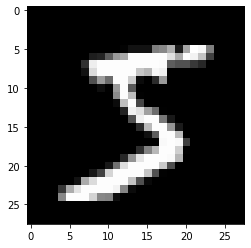

In [20]:
plt.imshow(train_dataset[0][0].reshape(28,28),"gray")
plt.show()

In [21]:
class Encoder(nn.Module):
    def __init__(self, d=10):
        super().__init__()
        self.flatten = nn.Flatten()
        self.dense = nn.Linear(28*28,512)
        self.leaky_relu = nn.LeakyReLU(0.2)
        self.dense_mean = nn.Linear(512,d)
        self.dense_log_var = nn.Linear(512,d)
        
    def forward(self, x):
        z = self.flatten(x)
        z = self.dense(z)
        z = self.leaky_relu(z)
        z_mean = self.dense_mean(z)
        z_log_var = self.dense_log_var(z)
        return z_mean, z_log_var


class Decoder(nn.Module):
    def __init__(self,d=10):
        super().__init__()
        self.dense = nn.Linear(d,512)
        self.leaky_relu = nn.LeakyReLU(0.2)
        self.dense2 = nn.Linear(512,28*28)
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, x):
        x = self.dense(x)
        x = self.leaky_relu(x)
        x = self.dense2(x)
        x = self.sigmoid(x)
        return x.view(-1,28,28)
    
    
class VAE(nn.Module):
    def __init__(self,flow,d=10):
        super().__init__()
        self.encoder = Encoder(d)
        self.decoder = Decoder(d)
        self.flow = flow
    
    def forward(self, x):
        mu, log_sigma = self.encoder(x)        
        z0 = mu+torch.randn(mu.shape, device=device)*torch.exp(log_sigma)
        zKs, log_det = self.flow(z0)
        y = self.decoder(zKs[-1])
        return y, mu, log_sigma, log_det

In [22]:
criterion = nn.BCELoss(reduction='sum')

def vae_loss(x, y, mu, log_sigma, log_det):    
    reconstruction_loss = criterion(y, x)
    kl_loss = -0.5*torch.sum(mu.pow(2)+log_sigma.exp()-log_sigma-1)
    
    return reconstruction_loss-kl_loss-log_det.sum()

In [23]:
radialFlows = [RadialFlow(10) for k in range(2)]
flow = NormalizingFlows(radialFlows)

model = VAE(flow, d=10).to(device)

optimizer = optim.Adam(model.parameters(), lr=1e-3)
print("number of params: ", sum(p.numel() for p in model.parameters()))

number of params:  820028


0 174.85314411090127 134.88692291552266


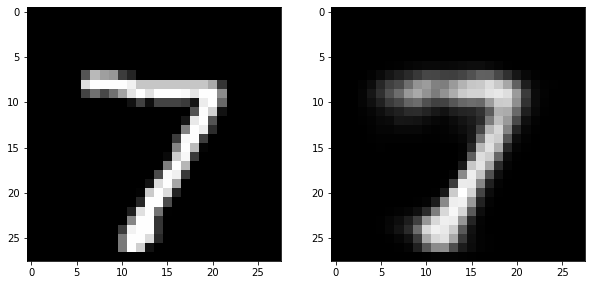

1 126.68146187376281 117.66274278537153
2 113.25464903960942 108.3566955468906
3 105.53276676918144 101.73038385165766
4 100.36236236615646 97.44522499352598
5 96.55114255361549 94.32751045592677
6 93.55020257642104 91.09033471250686
7 90.82841679858416 88.6629113633031
8 88.42363731422235 87.76959204140563
9 86.38369120345017 85.16670426926292
10 84.67346980915734 83.52746950094692
11 83.02159821944788 82.49912027962291
12 81.61324545637292 80.24863931089163
13 80.12727237747507 81.38912377646936
14 79.11789761931658 78.62130071865484
15 77.98092022904625 78.84316020880263
16 76.97364475274645 76.31723400274404
17 76.02368732878055 75.81080198440308
18 75.16137575476239 76.02048255993536
19 74.45474808183899 75.8179501177023
20 73.70883528459301 72.97912998626026
21 73.06155746611789 72.65901480239039
22 72.41778550896987 72.87197009443094
23 71.82458779959282 71.92675409530298
24 71.34026768297359 71.85705989313583
25 70.79109452172383 70.94417283176995
26 70.29574777458099 70.959957

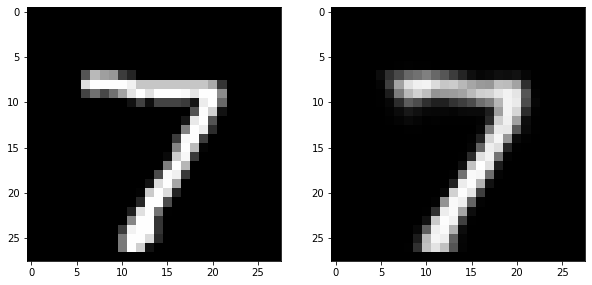

51 62.71655018853226 64.39071739367402
52 62.411783862300354 62.20099425392029
53 62.205700343605805 62.828499023145
54 62.12310680126416 62.49460351962251
55 61.989349324565964 64.24769079190092
56 61.77843560203221 64.93382539840552
57 61.71703082683159 62.93236709935977
58 61.34862438329332 62.141350962483465
59 61.19638015161445 61.395089877680086
60 61.104028136491266 62.43924754572372
61 60.971329502628976 60.92260881125355
62 60.633790271707525 62.36563536915155
63 60.5801256392641 60.86258590259491
64 60.219103023526344 60.98807302602945
65 60.22053151513637 62.5443696092112
66 60.14157418181224 61.438035581058585
67 59.760228572539084 61.50604568578945
68 59.5764750932749 60.96454469235941
69 59.594697508984794 61.74704568149944
70 59.39090436489428 60.76506420293936
71 59.31218011038644 60.1920051940333
72 59.12703690735601 61.90682155865069
73 58.86462632798098 60.01253149989314
74 58.724768052307866 59.89405190221037
75 58.749942587043854 60.42755602266842
76 58.52878584655

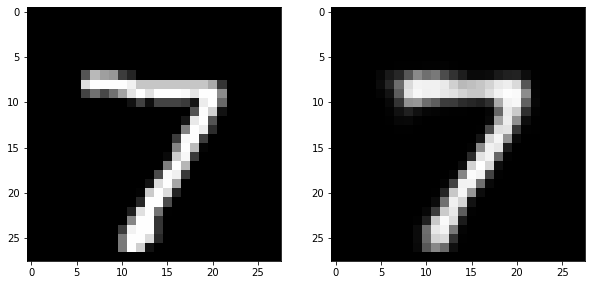

101 55.725276524069976 57.23918884326094
102 55.67119279819426 58.82204233724088
103 55.580022428250935 57.69819578956872
104 55.51194416146458 57.774131799277406
105 55.229937026749795 57.95979228644325
106 55.37363180338107 57.67848768630348
107 55.16909525423247 56.719983670658195
108 55.165217382651996 57.42640989504683
109 55.10577071568774 56.833783731673854
110 54.79319031965504 55.332852372727075
111 54.97034736313376 56.44251468158758
112 54.61466429601261 56.08302500910652
113 54.76475302039433 58.69103217810488
114 54.598029133268675 55.24144251278033
115 54.714517784525334 55.9442458594569
116 54.36498595334658 56.255188000468785
117 54.39712942485362 56.14556634921235
118 54.39141411906706 56.66127728349485
119 54.198971862901416 55.80551297367571
120 54.26508133650334 55.96325443499386
121 53.95950119734319 54.85570587060703
122 54.09696989459355 55.35896208644294
123 53.83322247123582 55.17174960249148
124 53.90388833637685 55.324933426829574
125 53.79464792171606 55.211

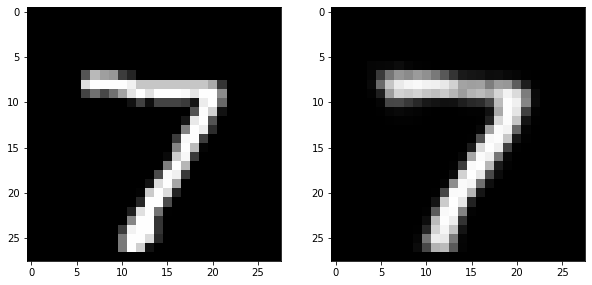

151 52.008536172743455 53.55205080075005
152 52.0538059470496 52.91454243279113
153 51.94787973432398 52.58073227854963
154 51.82323967148077 53.123818431037684
155 51.834567034083555 53.612549973752934
156 51.85692516996577 55.37046047369131
157 51.68286842883015 54.289316244399586
158 51.5681533461017 54.46500259009413
159 51.69257452340523 53.31198973244371
160 51.5022436520184 53.68138491840789
161 51.41226544410689 52.520983991531516
162 51.44493396653295 52.71163829523154
163 51.342425237247596 52.485489330352685
164 51.3383978983995 52.2485894151389
165 51.25243165125301 53.35581940964769
166 51.23137749114101 53.56121565358708
167 51.20335806254893 53.31537283266695
168 51.02442793585175 53.192296305403545
169 50.9985343618603 53.7538483592268
170 51.189125334869146 54.45865483634388
171 50.82464317641702 52.781128392813685
172 50.77293866122964 51.80515659807589
173 50.867862563143404 53.24497091275054
174 50.8030833994656 52.63312383048451
175 50.764143124318075 52.1245725954

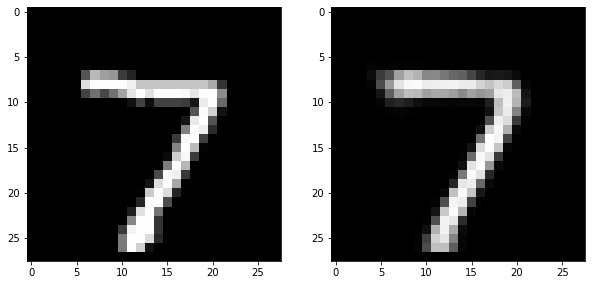

In [24]:
n_epochs = 201

losses = []
val_losses = []

for e in range(n_epochs):   
    loss_epoch = 0
    cpt_batch = 0
    
    for x_batch, _ in train_loader:
        x_batch = x_batch.to(device)
        
        model.train()
        
        yhat, mu, log_sigma, log_det = model(x_batch.reshape(-1,28,28))
        yhat = yhat.reshape(-1,1,28,28)
        
        l = vae_loss(x_batch, yhat, mu, log_sigma, log_det)
        
        l.backward()
        optimizer.step()
        optimizer.zero_grad()
        
        loss_epoch += l.item()/x_batch.size(0) ## Mean
        cpt_batch += 1
        
    losses.append(loss_epoch/cpt_batch)
    
    loss_val_epoch = 0
    cpt_batch = 0
        
    with torch.no_grad():
        for x_val, _ in test_loader:
            x_val = x_val.to(device)
            
            model.eval()
            yhat, mu, log_sigma, log_det = model(x_val.reshape(-1,28,28))
            yhat = yhat.reshape(-1,1,28,28)
            
            val_l = vae_loss(x_val,yhat,mu,log_sigma,log_det)
            loss_val_epoch += val_l.item()/x_val.size(0)
            cpt_batch += 1
            
        val_losses.append(loss_val_epoch/cpt_batch)
    
    print(e,losses[-1],val_losses[-1])
        
    if e%50 == 0:  
        for x_val, _ in test_loader:
            fig,ax = plt.subplots(1,2,figsize=(10,10))

            ax[0].imshow(x_val[0][0],"gray")

            x_val = x_val.to(device)

            model.eval()
            yhat, mu, sigma, log_det = model(x_val[0][0].reshape(-1,28,28))
            yhat = yhat.reshape(-1,1,28,28)
            ax[1].imshow(yhat[0][0].cpu().detach().numpy(),"gray")
            plt.show()
            break
        

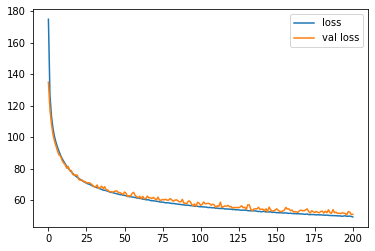

In [25]:
plt.plot(losses,label="loss")
plt.plot(val_losses,label="val loss")
plt.legend()
plt.show()

To do:
- Log Likelihood estimation
- Check ELBO (surprisingly low values)

## References

<a id="reference1"></a>

[1] Rezende, J.R., & Mohamed, S. Variational Inderence with Normalizing Flows. arXiv preprint arXiv:1505.05770. (2016). [link](https://arxiv.org/pdf/1505.05770)